# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

#import lightgbm as lgb
import xgboost as xgb
#import catboost as ctb
#from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 300
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")


# Preprocessing

In [5]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])


In [6]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df
    

# Pseudo Label

In [7]:
pseudo = pd.read_csv("../input/blending-tool-tps-aug-2021/file1_7.84987_file2_7.84996_blend.csv")[target]
test_pseudo = pd.concat([test, pseudo], axis=1)
all_pseudo = pd.concat([train, test_pseudo]).reset_index(drop=True)

# XGB

In [8]:
xgb_params = {
    'objective': 'reg:squarederror',    
    'n_estimators': N_ESTIMATORS,
    'importance_type': 'total_gain',
    'tree_method': 'gpu_hist',   
    'booster': 'gbtree',
    'n_jobs':-1,
    
    'learning_rate': 0.006926882143879833, 
    'subsample': 0.7665578211019899, 
    'colsample_bytree': 0.551350454117138,
    'max_depth': 21,
    'lambda': 2.7649143275388735, 
    'alpha': 26.355021643568286,
    'min_child_weight': 417.1915305746212
}


In [9]:
xgb_oof = np.zeros(train.shape[0])
xgb_pred = np.zeros(test.shape[0])
xgb_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=all_pseudo[scale_features], y=all_pseudo[target])):
    print(f"===== fold {fold} =====")
    if fold >= 5:
    
        oof_idx = np.array([idx for idx in val_idx if idx < train.shape[0]])
        preds_idx = np.array([idx for idx in val_idx if idx >= train.shape[0]])

        X_train, y_train = all_pseudo[scale_features].iloc[trn_idx], all_pseudo[target].iloc[trn_idx]
        #X_train = apply_noise_row(X_train)

        X_valid, y_valid = all_pseudo[scale_features].iloc[oof_idx], all_pseudo[target].iloc[oof_idx]
        X_test = all_pseudo[scale_features].iloc[preds_idx]



        # XGB       
        start = time.time()

        for inseed in seed_list:
            xgb_params['seed'] = inseed

            pre_model = xgb.XGBRegressor(**xgb_params)
            pre_model.fit(
                X_train, 
                y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='rmse',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE
            )


            xgb_params2 = xgb_params.copy()
            xgb_params2['lambda'] *= 0.9
            xgb_params2['alpha'] *= 0.9
            xgb_params2['learning_rate'] *= 0.1
            model = xgb.XGBRegressor(**xgb_params2)
            model.fit(
                    X_train, y_train,
                    eval_set=[(X_valid, y_valid)],
                    eval_metric='rmse',
                    early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                    verbose=VERBOSE,
                    xgb_model=pre_model
            )    

            with open(f"xgb_model{fold}.pkl", 'wb') as f:
                pickle.dump(model, f)

            fi_tmp = pd.DataFrame()
            fi_tmp['feature'] = X_train.columns
            fi_tmp['importance'] = model.feature_importances_
            fi_tmp['fold'] = fold
            fi_tmp['seed'] = inseed
            xgb_importances = xgb_importances.append(fi_tmp)

            xgb_oof[oof_idx] += model.predict(X_valid) / len(seed_list)
            xgb_pred[preds_idx-train.shape[0]] += model.predict(X_test) / len(seed_list)

        elapsed = time.time() - start
        rmse = mean_squared_error(y_valid, xgb_oof[oof_idx], squared=False)
        print(f"fold {fold} - xgb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

    
        
print(f"oof xgb_rmse = {mean_squared_error(train[target], xgb_oof, squared=False)}")

np.save("xgb_oof.npy", xgb_oof)
np.save("xgb_pred.npy", xgb_pred)


===== fold 0 =====
===== fold 1 =====
===== fold 2 =====
===== fold 3 =====
===== fold 4 =====
===== fold 5 =====
[0]	validation_0-rmse:10.13791
[1000]	validation_0-rmse:7.85391
[2000]	validation_0-rmse:7.83870
[3000]	validation_0-rmse:7.83456
[4000]	validation_0-rmse:7.83329
[5000]	validation_0-rmse:7.83184
[5041]	validation_0-rmse:7.83183
[0]	validation_0-rmse:7.83183
[624]	validation_0-rmse:7.83186
[0]	validation_0-rmse:10.13801
[1000]	validation_0-rmse:7.85531
[2000]	validation_0-rmse:7.83866
[3000]	validation_0-rmse:7.83336
[3940]	validation_0-rmse:7.83278
[0]	validation_0-rmse:7.83278
[1000]	validation_0-rmse:7.83257
[1488]	validation_0-rmse:7.83251
[0]	validation_0-rmse:10.13782
[1000]	validation_0-rmse:7.85639
[2000]	validation_0-rmse:7.84119
[3000]	validation_0-rmse:7.83765
[4000]	validation_0-rmse:7.83515
[4327]	validation_0-rmse:7.83557
[0]	validation_0-rmse:7.83557
[1000]	validation_0-rmse:7.83535
[2000]	validation_0-rmse:7.83520
[2562]	validation_0-rmse:7.83519
fold 5 - xg

# OOF predictions

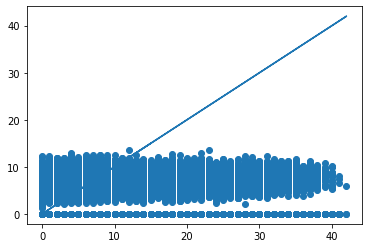

In [10]:
plt.plot(train[target], train[target])
plt.scatter(train[target], xgb_oof)

# Features importances

Text(0.5, 1.0, 'XGBoost feature importances')

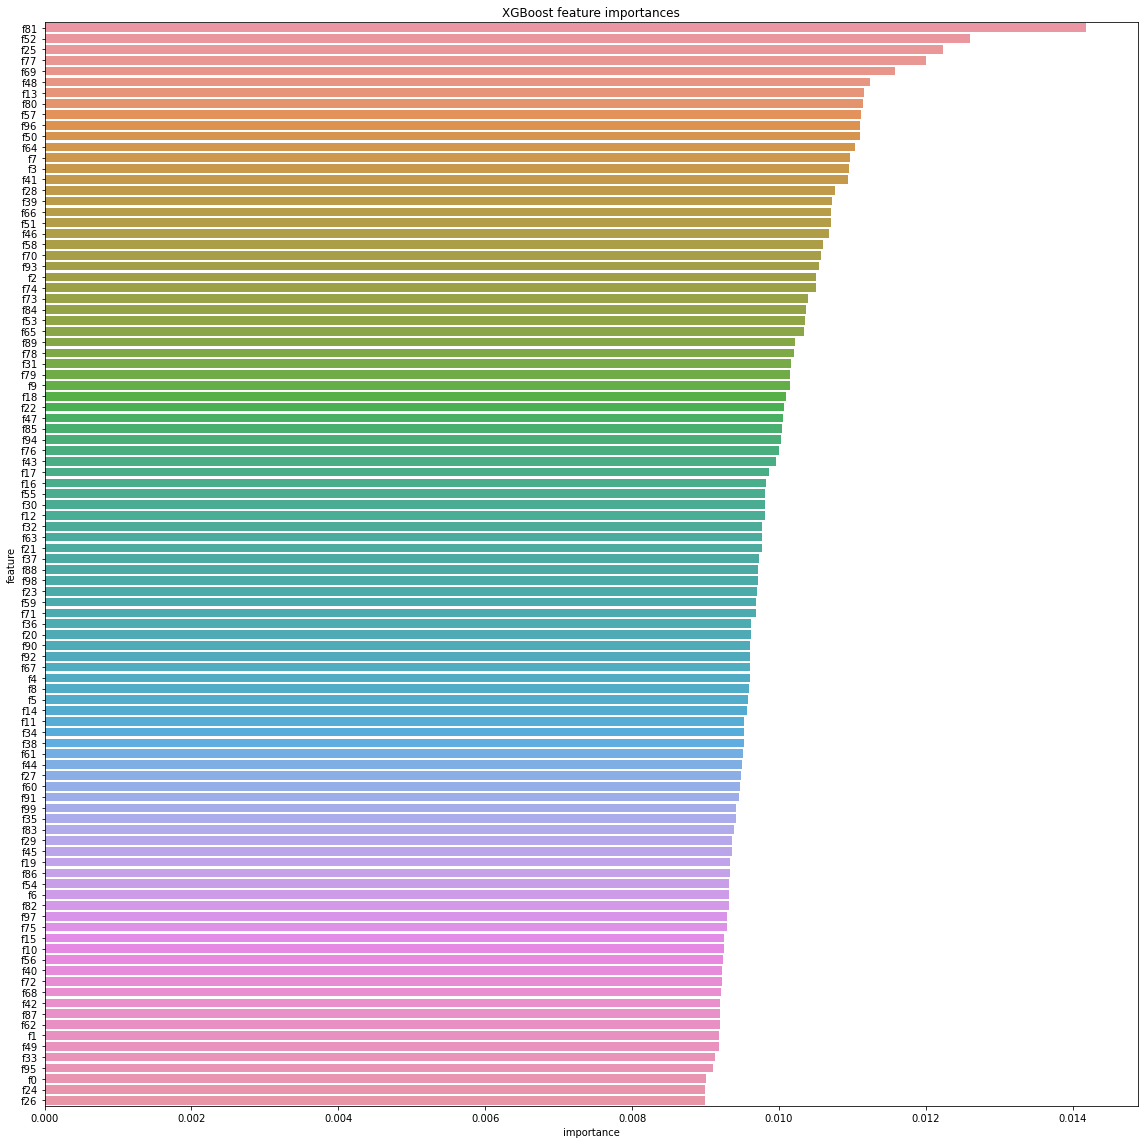

In [11]:
order = list(xgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=xgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("XGBoost feature importances")

# Submission

In [12]:
submission[target] = xgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,0.000000
1,250001,5.237488
2,250002,0.000000
3,250003,0.000000
4,250004,0.000000
...,...,...
149995,399995,0.000000
149996,399996,0.000000
149997,399997,0.000000
149998,399998,0.000000


# Log

ver1 fold 0-4

ver2 fold 5-9